In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio
from sklearn.model_selection import train_test_split


from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier



In [82]:
pd.set_option('display.max_columns', None)


### Reading Data

In [83]:
df = pd.read_csv('/kaggle/input/musicgenreclassification/features_30_sec.csv')

### EDA

In [84]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [85]:
df.shape

(1000, 60)

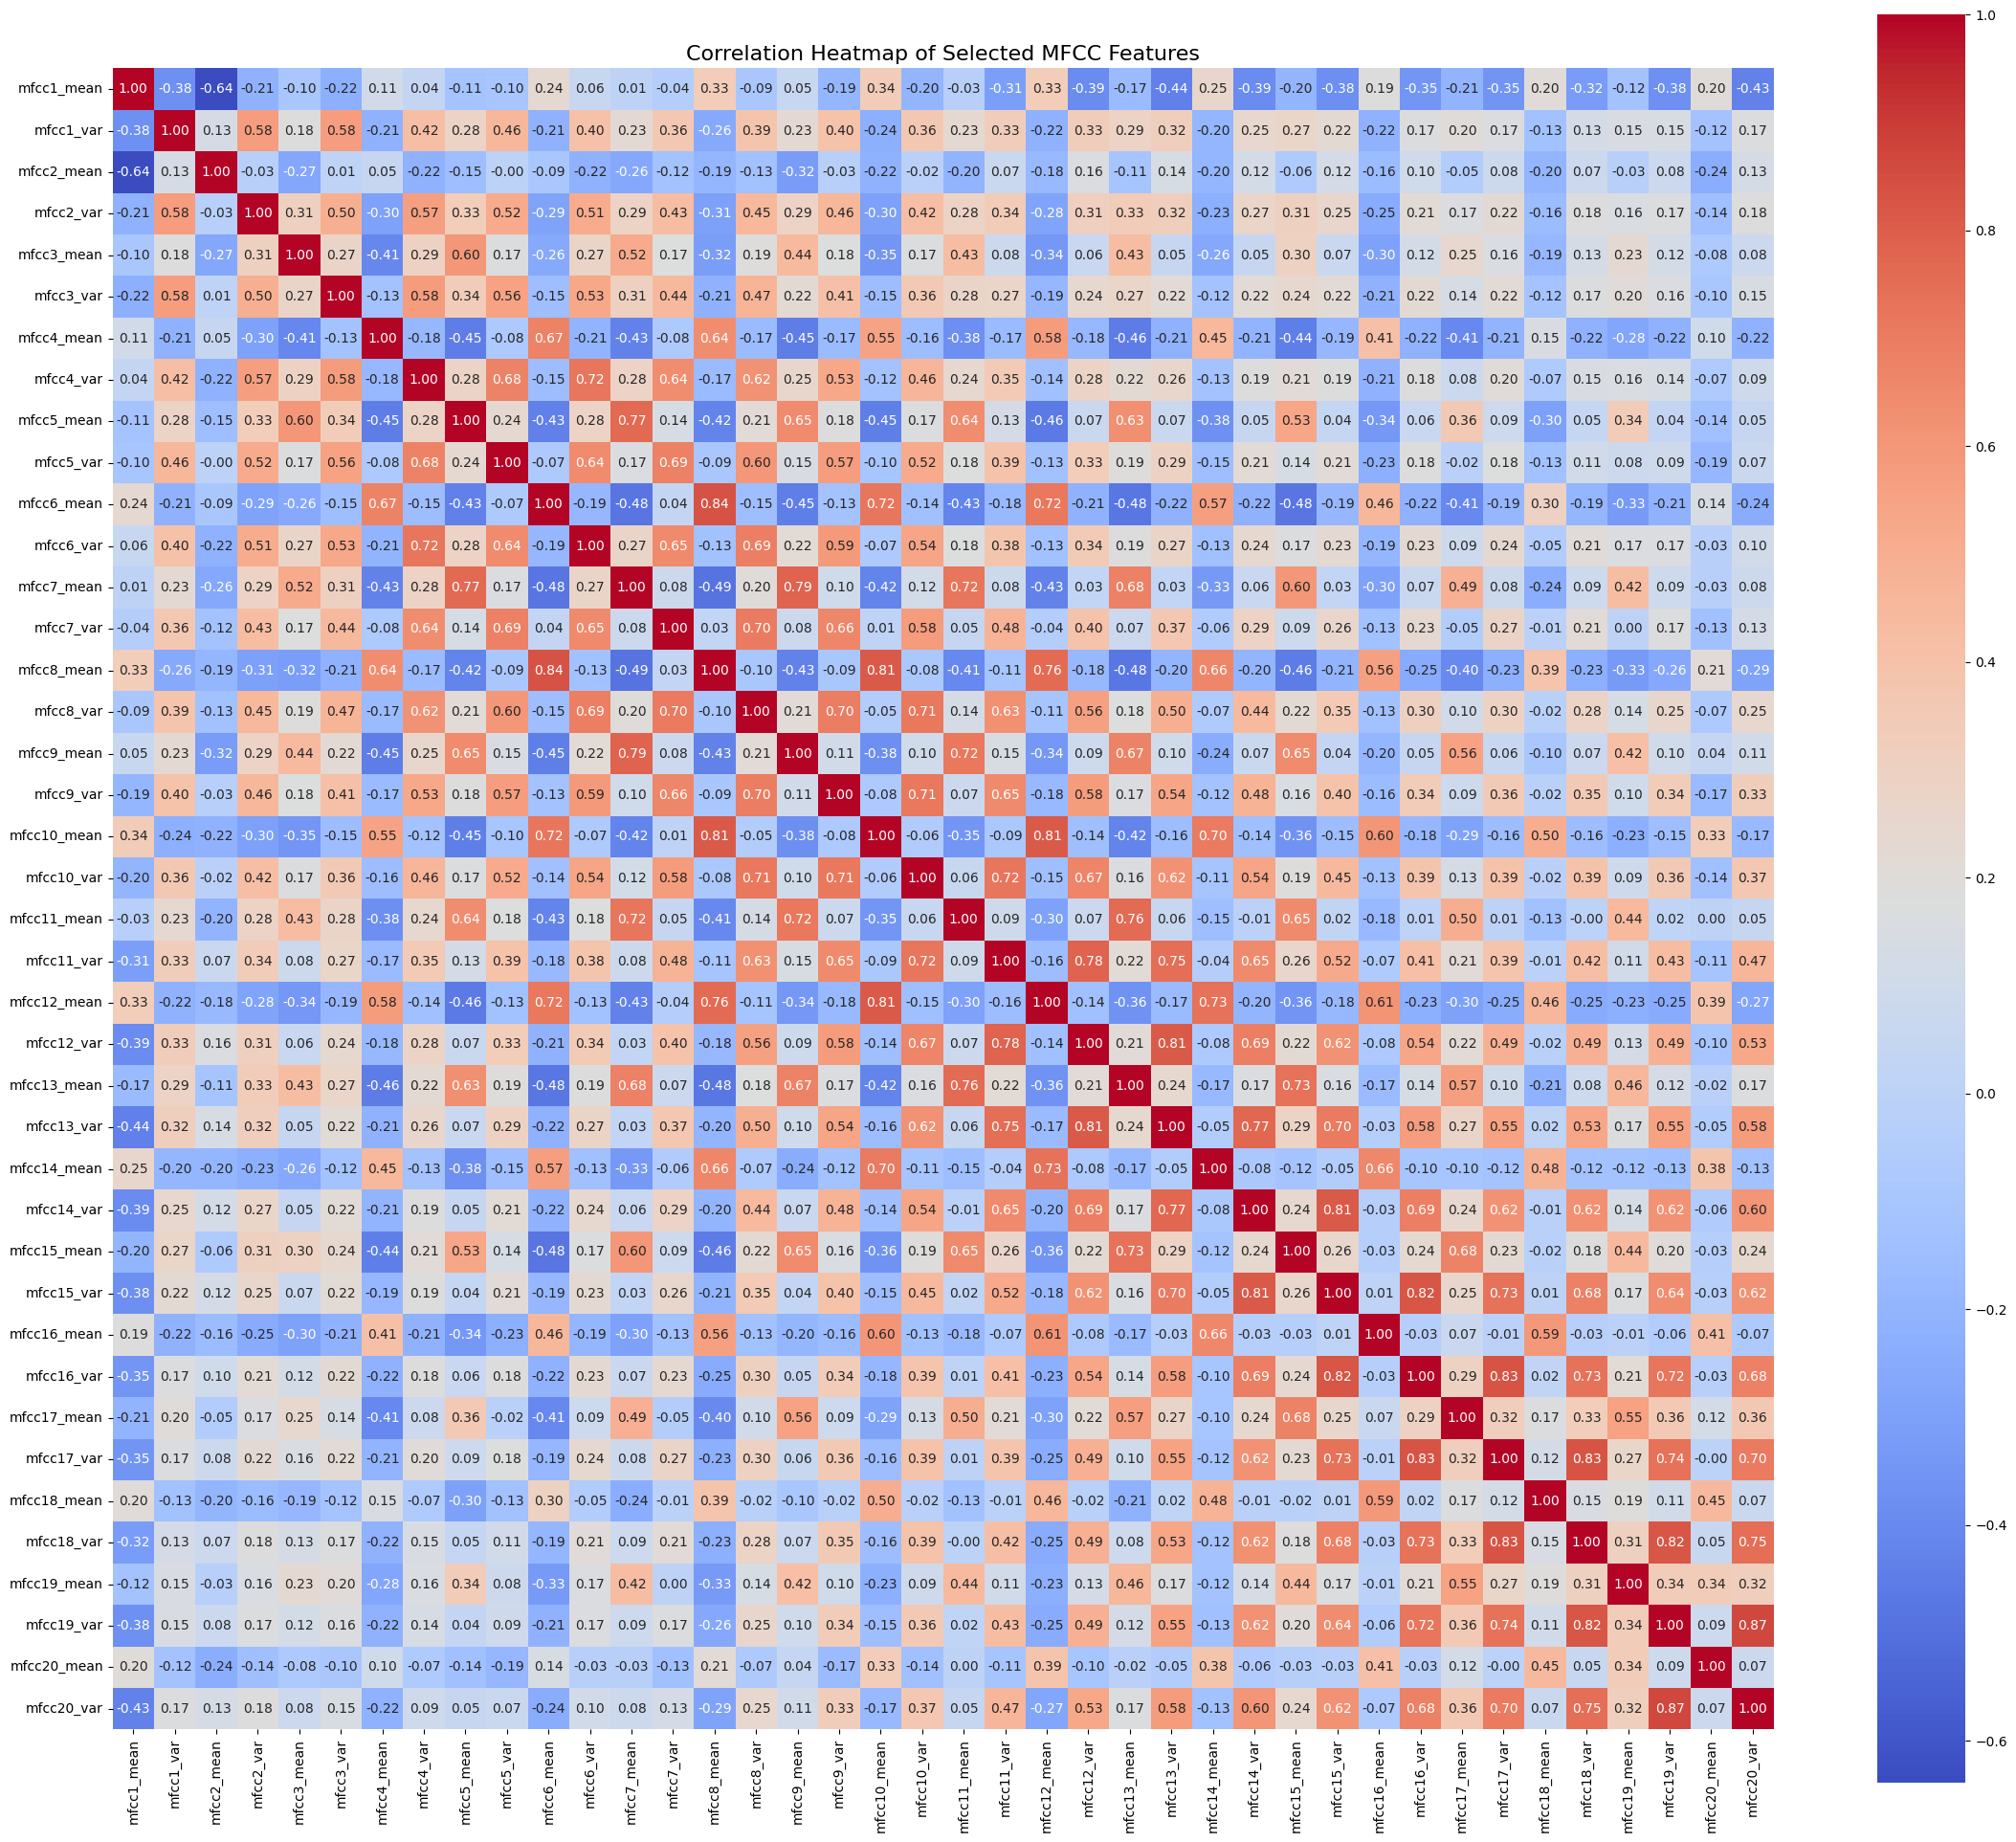

In [86]:

selected_columns = [col for col in df.columns if "mfcc" in col.lower()]
subset_corr = df[selected_columns].corr()

plt.figure(figsize=(28, 24))
sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap of Selected MFCC Features", fontsize=16)
plt.show()

In [87]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

### Feature Engineering / Train Test split

In [88]:
if df['label'].dtype == 'object':
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

In [89]:
df.drop(columns = ['filename'], inplace = True)

y = df['label']
X = df.drop(columns = ['label'])


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (800, 58)
Testing set shape: (200, 58)


In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
results = {}

### Model Training

#### KNN

In [93]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test_scaled)

# Calculate accuracy on the test set
knn_accuracy = accuracy_score(y_test, y_pred)
print("KNN Model Test Accuracy:", knn_accuracy)

# Save the test accuracy into the results dictionary with key 'KNN'
results['KNN'] = knn_accuracy

# Optionally, print the dictionary to verify
print("Results:", results)

KNN Model Test Accuracy: 0.645
Results: {'KNN': 0.645}


#### RandomForest

In [94]:
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Predict the labels for the test data
y_pred = rf_model.predict(X_test_scaled)

# Calculate the test accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Test Accuracy:", rf_accuracy)

# Save the test accuracy into the results dictionary under the key 'RandomForest'
results['RandomForest'] = rf_accuracy

# Optionally, print the results dictionary to verify the stored result
print("Results:", results)

Random Forest Test Accuracy: 0.755
Results: {'KNN': 0.645, 'RandomForest': 0.755}


#### XgBoost

In [95]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy on the test set
xgb_accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Model Test Accuracy:", xgb_accuracy)

# Save the test accuracy into the results dictionary under the key 'XGBoost'
results['XGBoost'] = xgb_accuracy

# Print out the results dictionary to verify
print("Results:", results)

XGBoost Model Test Accuracy: 0.775
Results: {'KNN': 0.645, 'RandomForest': 0.755, 'XGBoost': 0.775}


### XgBoost tuned

In [119]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# 1️⃣ Define the base model
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 2️⃣ Specify the hyperparameter search space
param_dist = {
    'n_estimators':      [100, 200, 500, 800, 1000],
    'max_depth':         [3, 5, 7, 9],
    'learning_rate':     [0.01, 0.05, 0.1, 0.2],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 0.1, 0.2, 0.3],
    'reg_alpha':         [0, 0.01, 0.1, 1],
    'reg_lambda':        [1, 1.5, 2, 3]
}

# 3️⃣ Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,            # number of parameter settings sampled
    scoring='accuracy',   # optimize for accuracy
    cv=5,                 # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1             # use all cores
)

# 4️⃣ Run the search on the training set
rand_search.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=1000, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=  38.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=500, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=  30.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=1000, reg_alpha=1, reg_lambda=3, subsample=0.8; total time=  10.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=1000, reg_alpha=1, reg_lambda=3, subsample=0.8; total time=   9.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=1000, reg_alpha=1, reg_lambda=3, subsample=0.8; total time=   9.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=1.0; total time=   5.7s
[CV] END colsamp

In [120]:
# 5️⃣ Examine the best hyperparameters and CV score
print("Best hyperparameters:", rand_search.best_params_)
print("Best CV accuracy    :", rand_search.best_score_)

# 6️⃣ Evaluate the tuned model on the test set
best_xgb = rand_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print("Tuned XGBoost Test Accuracy:", tuned_accuracy)

# 7️⃣ Save into your results dictionary
results['XGBoost_tuned'] = tuned_accuracy
print("Updated Results:", results)

Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV accuracy    : 0.8000000000000002
Tuned XGBoost Test Accuracy: 0.79
Updated Results: {'KNN': 0.645, 'RandomForest': 0.755, 'XGBoost': 0.775, 'NeuralNetwork': 0.7549999952316284, 'XGBoost_tuned': 0.79}


In [126]:
import json

# Write them to disk
with open('xgb_tuned_params.json', 'w') as fp:
    json.dump(rand_search.best_params_, fp, indent=4)


best_xgb.save_model("xgb_tuned.json")

#### Neural Network

In [116]:
from tensorflow.keras import regularizers

num_classes  = y_train.nunique()

l2_factor = 1e-4

nn_model_deep = Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),

    Dense(
        512,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor)
    ),
    Dropout(0.4),
    BatchNormalization(),

    Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor)
    ),
    Dropout(0.4),
    
    BatchNormalization(),
        Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor)
    ),
    Dropout(0.4),
    BatchNormalization(),

    Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor)
    ),
    Dropout(0.4),
    BatchNormalization(),

    Dense(
        16,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor)
    ),
    Dropout(0.4),
    BatchNormalization(),

    Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor)
    )
])

# Compile the model
nn_model_deep.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up EarlyStopping to monitor validation loss with increased patience to allow more training time
early_stop_deep = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model_deep.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 512)                 │          30,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,802 (811.73 KB)

 Trainable params: 205,850 (804.10 KB)

 Non-trainable params: 1,952 (7.62 KB)

In [117]:
checkpoint_filepath_nn = 'best_nn_model.keras'
model_checkpoint_callback_nn = ModelCheckpoint(
    filepath=checkpoint_filepath_nn,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

In [118]:
history_deep = nn_model_deep.fit(X_train_scaled, y_train,
                                 validation_split=0.2,
                                 epochs=200,
                                 batch_size=128,
                                callbacks=[model_checkpoint_callback_nn],
                                 verbose=1)

# Evaluate the deeper model on the test set
test_loss_deep, test_accuracy_deep = nn_model_deep.evaluate(X_test_scaled, y_test, verbose=0)

results['NeuralNetwork'] = test_accuracy_deep


nn_model_deep.save("best_neural_network_model.h5")


print("Deeper Neural Network Model Accuracy:", test_accuracy_deep)

Epoch 1/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.1016 - loss: 2.7634
Epoch 1: val_accuracy improved from -inf to 0.14375, saving model to best_nn_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.1073 - loss: 2.7272 - val_accuracy: 0.1437 - val_loss: 2.3481
Epoch 2/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1250 - loss: 2.8307
Epoch 2: val_accuracy improved from 0.14375 to 0.20000, saving model to best_nn_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1274 - loss: 2.7274 - val_accuracy: 0.2000 - val_loss: 2.3137
Epoch 3/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1406 - loss: 2.5648
Epoch 3: val_accuracy improved from 0.20000 to 0.28750, saving model to best_nn_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1386 - loss: 2.5902 - val_accuracy: 0.2875 - val_loss: 2.2710
Epoch 4/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1641 - loss: 2.5428
Epoch 4: val_accuracy improved from 0.28750 to 0

#### LSTM

In [ ]:

lstm_model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1), recurrent_dropout=0.3,
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

In [ ]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = lstm_model.fit(
    X_train_scaled, y_train,
    batch_size=128,
    validation_split=0.2,
    epochs=500,
    callbacks=[model_checkpoint_callback],
    verbose=1
)
test_loss_deep_lstm, test_accuracy_deep_lstm = lstm_model.evaluate(X_test_scaled, y_test, verbose=0)

results['LSTM'] = test_accuracy_deep_lstm


# nn_model.save("best_lstm.h5")


print("Deeper Neural Network Model Accuracy:", test_accuracy_deep_lstm)


### Final Results

In [ ]:
results

### Experimentation 1

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

# 1) Force Python, NumPy, and TF hashes & RNGs to be deterministic
os.environ['PYTHONHASHSEED']     = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 2) Prepare experiment container
exper1 = {}
test_sizes = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.35]

for test_size in test_sizes:
    # 3) Split with fixed seed
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42,  # ensures same split every time
        shuffle=True
    )

    # 4) Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # 5) Clone & compile model after seeding
    tf.random.set_seed(42)  # reseed before weight init
    nn_model = tf.keras.models.clone_model(nn_model_deep)
    nn_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 6) Setup checkpoint
    checkpoint_filepath = f'best_model_{int(test_size*100)}.keras'
    ckpt_cb = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )

    # 7) Train (deterministically)
    history = nn_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=512,
        batch_size=128,
        callbacks=[ckpt_cb],
        verbose=0
    )

    # 8) Evaluate & record
    loss, acc = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
    exper1[f"test_size_{int(test_size*100)}"] = {
        "Test_Accuracy": acc,
        "Model": nn_model
    }

    print(f"Test size={test_size:.3f} → Accuracy={acc:.4f}")

In [ ]:
test_sizes = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.35]

# Match test_sizes to dictionary keys
print("\n📊 Test Accuracies by Test Set Size:\n" + "-"*45)
for i, test_size in enumerate(test_sizes):
    key = f"test_size_{int(test_size*100):02d}"
    acc = exper1[key]['Test_Accuracy']
    print(f"Test size = {test_size:<6} →  Accuracy: {acc:.4f}")

# Find the best performing model
best_key = max(exper1, key=lambda k: exper1[k]['Test_Accuracy'])
best_acc = exper1[best_key]['Test_Accuracy']
best_model = exper1[best_key]['Model']

# Extract the corresponding test size from the list
best_index = list(exper1.keys()).index(best_key)
best_test_size = test_sizes[best_index]

print("\n🏆 Best Performing Split:")
print(f"Test size = {best_test_size} with Accuracy: {best_acc:.4f}")

# Save best model
filename = f"best_model_testsize_{str(best_test_size).replace('.', '_')}.h5"
best_model.save(filename)
print(f"\n💾 Best model saved as: {filename}")

In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
test_sizes = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.35]
accuracies = [exper1[f"test_size_{int(ts*100)}"]["Test_Accuracy"] for ts in test_sizes]

# Plot the test accuracy line
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, accuracies, color='black', linewidth=2.5, label='Model A')

# Optional: add baseline (e.g., 0.5)
baseline = 0.5
plt.axhline(y=baseline, color='lightgray', linestyle='--', linewidth=1.5)
plt.text(test_sizes[-1] + 0.005, baseline + 0.005, "Baseline", color='gray')

# Labels for each axis
plt.xlabel("Test Size", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)

# Annotate the highest point
best_idx = int(np.argmax(accuracies))
plt.text(test_sizes[best_idx], accuracies[best_idx] + 0.02,
         f"{accuracies[best_idx]*100:.1f}%", color='black', fontsize=12)

# Add model label at end of line
plt.text(test_sizes[-1] + 0.005, accuracies[-1], "Model A", fontsize=12, color='black')

# Grid and title
plt.grid(alpha=0.3)
plt.title("Test Accuracy by Test Set Size", fontsize=14)

# Plot style
plt.ylim(0, 1.05)
plt.xlim(min(test_sizes) - 0.01, max(test_sizes) + 0.03)
plt.xticks(test_sizes)
plt.tight_layout()
plt.savefig('ModelSplitPerformance.png')
plt.show()

In [ ]:
best_model = exper1[best_key]["Model"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.125, random_state=42
)

# 2. Scale test data using the same method as before
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 4. Predict class probabilities and convert to labels
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# 5. Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy (confirmed): {test_accuracy:.4f}")

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
genre_labels = le.inverse_transform(np.arange(10))  # Map class numbers to genre names

# 7. Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)

plt.title("Confusion Matrix - Feature Based Classifier", fontsize=14)
plt.xlabel("Predicted Genre", fontsize=12)
plt.ylabel("True Genre", fontsize=12)
plt.tight_layout()
plt.savefig('Confusion')
plt.show()

In [ ]:
results

### Feature Extraction Automation

In [ ]:
class AudioFeature:
    import os 
    import numpy as np
    import librosa

    def __init__(self, path):
        self.path = path

        if os.path.exists(self.path):
            self.y, self.sr = librosa.load(self.path)

        else:
            raise Exception(f"Path not found - {self.path}")

        self.load_audio_file()


    def get_dataframe(self):
        """
        Return all extracted features as a single-row pandas DataFrame
        with columns matching the feature names.
        """
        features = self.get_all_params()
        
        df = pd.DataFrame([features])
        
        return df

    def get_all_params(self):

        self.get_length()
        self.get_zero_crossings()
        self.get_tempo()
        self.get_centroids()
        self.get_spectral_rolloff()
        self.get_mel_frequencies()
        self.get_chroma()
        self.get_rms()
        self.get_spectral_bandwith()
        self.get_harmony()
        self.get_perceptr()
        
        result = {
            "length" : self.length,
            "chroma_stft_mean" : self.chroma_stft_mean,
            "chroma_stft_var" : self.chroma_stft_var,
            "rms_mean" : self.rms_mean,
            "rms_var" : self.rms_var,
            "spectral_centroid_mean" : self.spectral_centriod_mean,
            "spectral_centroid_var" : self.spectral_centriod_var,
            "spectral_bandwith_mean" : self.spectral_bandwith_mean,
            "spectral_bandwith_var" : self.spectral_bandwith_var,
            "rolloff_mean" : self.rolloff_mean,
            "rolloff_var" : self.rolloff_var,
            "zero_crossing_rate_mean": self.zero_crossings_rate_mean,
            "zero_crossing_rate_var" : self.zero_crossings_rate_var,
            "harmony_mean" : self.harmony_mean,
            "harmony_var" : self.harmony_var,
            "perceptr_mean" : self.perceptr_mean,
            "perceptr_var": self.perceptr_var,
            "tempo" : self.tempo

        }

        result.update(self.mel_frequencies)

        return  result


    def load_audio_file(self):
        self.audio_file, _ = librosa.effects.trim(self.y)

        return self.audio_file

    def get_harmony(self):
        harmony = librosa.effects.harmonic(y = self.audio_file)
        self.harmony_mean = np.mean(harmony)
        self.harmony_var = np.var(harmony)

        return self.harmony_mean, self.harmony_var
        

    def get_length(self):
        self.length = np.shape(self.audio_file)[0]
        
        return self.length

    def get_zero_crossings(self):
        zero_crossings = librosa.zero_crossings(self.audio_file, pad=False)

        self.zero_crossings_rate_mean = np.mean(zero_crossings)
        self.zero_crossings_rate_var = np.var(zero_crossings)

        return self.zero_crossings_rate_mean, self.zero_crossings_rate_var

    def get_rms(self):
        rms = librosa.feature.rms(y = self.audio_file)

        self.rms_mean = np.mean(rms)
        self.rms_var = np.var(rms)

        return self.rms_mean, self.rms_var

    def get_spectral_bandwith(self):
        spectral_bandwith = librosa.feature.spectral_bandwidth(y = self.audio_file, sr = self.sr)
        self.spectral_bandwith_mean = np.mean(spectral_bandwith)
        self.spectral_bandwith_var = np.var(spectral_bandwith)

        return self.spectral_bandwith_mean, self.spectral_bandwith_var
    

    def get_tempo(self):
        # Estimate tempo (BPM) from your audio time series
        self.tempo, _ = librosa.beat.beat_track(
            y=self.y,
            sr=self.sr
        )

        self.tempo = self.tempo[0]
        
        return self.tempo

    def get_centroids(self):
        spectral_centroids = librosa.feature.spectral_centroid(y = self.audio_file, sr=self.sr)[0]

        self.spectral_centriod_mean = np.mean(spectral_centroids)
        self.spectral_centriod_var = np.var(spectral_centroids)

        return self.spectral_centriod_mean, self.spectral_centriod_var

    def get_perceptr(self):
        # 1. Compute Mel‐spectrogram
        S = librosa.feature.melspectrogram(
            y=self.audio_file,
            sr=self.sr,
            hop_length=5000,
        )
        
        pcen = librosa.pcen(
            S,
            sr=self.sr,
            hop_length=5000,
        )
        
        # 3. Compute statistics
        self.perceptr_mean = np.mean(pcen)
        self.perceptr_var  = np.var(pcen)
        
        
        return pcen
    
    def get_spectral_rolloff(self):

        spectral_rolloff = librosa.feature.spectral_rolloff(y = self.audio_file, sr=self.sr)[0]

        self.rolloff_mean = np.mean(spectral_rolloff)
        self.rolloff_var = np.var(spectral_rolloff)


        return self.rolloff_mean, self.rolloff_var

    def get_chroma(self, hop_length = 5000):
        
        chromagram = librosa.feature.chroma_stft(y = self.audio_file, sr=self.sr, hop_length=hop_length)
        self.chroma_stft_mean = np.mean(chromagram)
        self.chroma_stft_var = np.var(chromagram)

        return self.chroma_stft_mean , self.chroma_stft_var
    
    def get_mel_frequencies(self):
        mfccs = librosa.feature.mfcc(y = self.audio_file, sr=self.sr)
        self.mel_frequencies = {}
        for i, mfcc in enumerate( mfccs):
            self.mel_frequencies[f'mfcc{i+1}_mean'] = np.mean(mfcc)
            self.mel_frequencies[f'mfcc{i+1}_var'] = np.var(mfcc)

        return self.mel_frequencies
        

In [ ]:
test_input_path = '/kaggle/input/musicgenreclassification/genres_original/blues/blues.00000.wav'

audio_features = AudioFeature(test_input_path)

df = audio_features.get_dataframe()

In [ ]:
df